In [5]:
from sklearn.manifold import MDS
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from concurrent import futures
from sklearn.neighbors import KNeighborsClassifier
import h5py

import dtw
import sys
sys.path.append('../')
import util

## DTW

We use [Dynamic Time Warping](https://masterwangzx.com/2019/02/06/dtw/) to calculate the distance of each sample. It takes a lot of time.

In [6]:
# number of good sample, this must bigger than 50. The bigger the more time cost.
num = 50

data, num_good, num_bad = util.load_data(num)
dist = np.zeros((len(data), len(data)))


def get_dist(data, index1, index2):
    distance, cost, path = dtw.dtw(data[index1], data[index2])
#     print('complete ({d1},{d2})'.format(d1=index1, d2=index2))
    return distance, index1, index2


process = [(i, j) for i in range(len(data)) for j in range(i + 1, len(data))]

with futures.ProcessPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(get_dist, data, item[0], item[1]) for item in process]
    for future in futures:
        distance, index1, index2 = future.result()
        dist[index1, index2] = distance

for i in range(len(data)):
    for j in range(0, i):
        dist[i, j] = dist[j, i]


Now we can use MDS to visualize what we calculate.

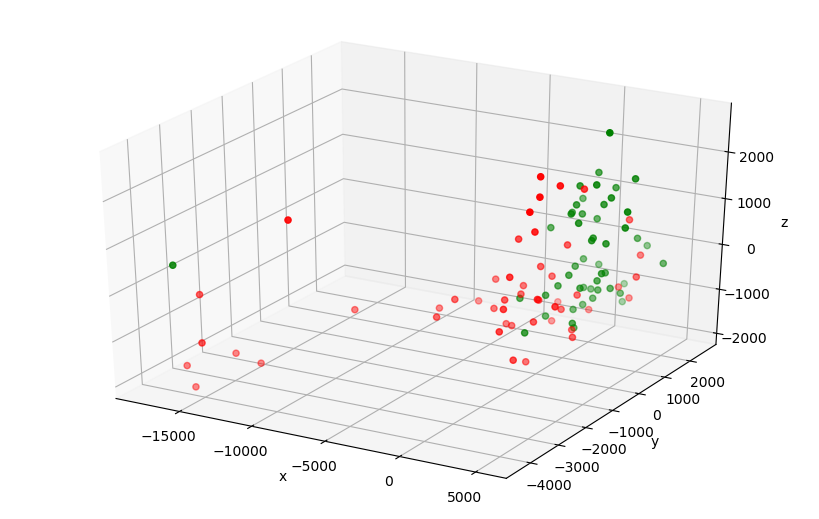

In [7]:
mds = MDS(n_components=3, dissimilarity="precomputed")
pos = mds.fit_transform(dist)

fig = plt.figure(figsize=(8, 5), dpi= 100)
ax = Axes3D(fig)
ax.scatter(pos[:num, 0], pos[:num, 1], pos[:num, 2], c='g')
ax.scatter(pos[num:, 0], pos[num:, 1], pos[num:, 2], c='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

Use KNN to see how is DTW performing.

In [8]:
# prepare data
labels = np.array([1]*(len(pos)-50)+[0]*50,dtype=np.int)
train_x = pos[10:-10, :]
train_y = labels[10:-10]
test_x = np.vstack((pos[:10, :], pos[-10:, :]))
test_y = np.hstack((labels[:10], labels[-10:]))

# KNN
neigh = KNeighborsClassifier(n_neighbors=2, weights='distance')
neigh.fit(train_x, train_y)
neigh.score(test_x, test_y)

0.65